### Load the 5000-row CSV

In [2]:
import pandas as pd

# Point to the CSV you uploaded
file_path = "hn_5000.csv"

# Load it
df = pd.read_csv(file_path)

# Inspect columns to find which column holds the text
print("Columns available:", df.columns.tolist())
display(df.head(3))

Columns available: ['title', 'url', 'text', 'dead', 'by', 'score', 'time', 'timestamp', 'type', 'id', 'parent_x', 'descendants', 'ranking', 'deleted', 'parent_y', 'content']


,title,url,text,dead,by,score,time,timestamp,type,id,parent_x,descendants,ranking,deleted,parent_y,content
0,Tentative tree planting 'decades overdue' in s...,https://phys.org/news/2025-04-tentative-tree-d...,NaN,NaN,PaulHoule,10,1747265568,2025-05-14 23:32:48+00:00,story,43990286,NaN,0.0,NaN,NaN,NaN,tentative tree planting decades overdue in sw...
1,Close to the metal: web design and the browser,https://goodinternetmagazine.com/close-to-the-...,NaN,NaN,ovidem,2,1748717251,2025-05-31 18:47:31+00:00,story,44146209,NaN,0.0,NaN,NaN,44146209.0,close to the metal web design and the browser
2,Ask HN: What browser do y'all use?,NaN,An age-old question. I&#x27;ve been testing ou...,NaN,br0gi3,4,1740168491,2025-02-21 20:08:11+00:00,story,43132327,NaN,21.0,NaN,NaN,43132327.0,duckduckgo very performant maybe because of th...


### Updated Normalization + Blacklist Code

In [3]:
from keybert import KeyBERT
import re

# Initialize KeyBERT with an open-source SBERT model
kb_model = KeyBERT(model="all-MiniLM-L6-v2")

# Clean the content
def clean_content(text):
    # Remove http(s) links
    text = re.sub(r"http\S+", "", text)
    return text.strip()

df["clean_content"] = df["content"].astype(str).apply(clean_content)

# The blacklist filters out unhelpful words
BLACKLIST = {
    "yc", "ycombinator", "y combinator", "s19", "w18", "w19", "f24", "f23",
    "accelerator", "seed", "funding", "series a", "series b",
    "new", "latest", "best", "top", "vs", "versus", "what", "why", "how",
    "when", "where", "is", "are", "was", "were", "this", "that", "it", "they", "we", "u", "ur",
    "000", "10", "11", "12", "13", "14", "15", "16", "18", "19", "1b", "1m", "20",
    "22", "24", "25", "26", "30", "32", "3d", "40", "4b", "4o", "50", "5b", "5k",
    "64", "80", "90", "95", "100", "200", "2010", "2011", "2012", "2014",
    "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023",
    "2024", "2025", "250"
}
SYN_MAP = {
    "ml": "machine learning",
    "vc": "venture capital",
    "ai": "artificial intelligence"
}

def normalize_phrase(phrase: str) -> str:
    p = phrase.lower().strip()  # converting to lowercase
    p = re.sub(r"[^\w\s]", "", p) # removing symbols and extra spaces
    p = p.replace("-", " ") # replacing some short forms, like ‘AI’ with ‘artificial intelligence
    p = re.sub(r"\s+", " ", p).strip()

    # Check if ANY token in the phrase is blacklisted
    words = set(p.split())
    if words & BLACKLIST or len(p) < 2:
        return None

    return SYN_MAP.get(p, p)

def filter_and_normalize(raw_list: list) -> list:
    seen, out = set(), []
    for ph in raw_list:
        norm = normalize_phrase(ph)
        if norm and norm not in seen:
            out.append(norm)
            seen.add(norm)
    return out or ["untagged"]

### KeyBERT

we use the KeyBERT model, which is based on sentence transformers, to extract keywords from each article. It finds the most relevant phrases by looking at the semantic meaning of the text — not just frequency.

In [4]:
from tqdm import tqdm

# Run KeyBERT on all 5,000 rows in batches of 32
all_texts = df["clean_content"].tolist()
all_raw = []
batch_size = 32
top_n = 8

for i in tqdm(range(0, len(all_texts), batch_size), desc="KeyBERT on all rows"):
    batch = all_texts[i : i + batch_size]
    try:
        batch_results = kb_model.extract_keywords(
            batch,
            keyphrase_ngram_range=(1, 3),
            stop_words="english", #is limited, only filters a basic set of English stopwords, not short phrases
            top_n=top_n,
            use_mmr=True,
            diversity=0.7
        )
        for sublist in batch_results:
            phrases = [phrase for phrase, score in sublist]
            all_raw.append(phrases)
    except Exception as e:
        print(f"Error in batch {i}: {e}")
        all_raw.append([])

# Trim to match dataframe
all_raw = all_raw[: len(df)]
df["keybert_raw"] = all_raw
df["keybert_tags"] = df["keybert_raw"].apply(filter_and_normalize)

print("\nFirst 10 rows with cleaned content and final tags:")
display(df[["clean_content", "keybert_tags"]].head(10))


KeyBERT on all rows: 100%|███████████████████████████████████████████████████████████| 157/157 [27:10<00:00, 10.39s/it]


First 10 rows with cleaned content and final tags:


,clean_content,keybert_tags
0,tentative tree planting decades overdue in swe...,"[overdue sweltering athens, tree planting, pla..."
1,close to the metal web design and the browser,"[metal web design, close metal web, web design..."
2,duckduckgo very performant maybe because of th...,"[firefox chrome, 1password feature lean, impor..."
3,accelerate cpu based llm inference with a vect...,"[llm inference vector, cpu based llm, index ou..."
4,very good example to learn async will try it i...,"[coroutine event_loop main, python micro event..."
5,gold recovery from e waste by food waste amylo...,"[waste amyloid aerogels, food waste amyloid, g..."
6,introducing bitcaskdb a fast lightweight and f...,"[storageengine bitcaskdb opensource, lightweig..."
7,helrom trailer rail roll on off system for tra...,"[trailer rail roll, helrom trailer rail, trans..."
8,i have to wonder how much of that article is l...,"[market theory claims, llm generated, network ..."
9,archive is hvgmfactual memorandum from whiteho...,"[hvgmfactual memorandum whitehouse, banning je..."


### TF–IDF + KMeans Clustering
We then apply the TF-IDF vectorizer. This converts the tag text into a numerical matrix where each column is a keyword and each row is an article.

In [6]:
# Prepare a “Tag‐Document” per Row
df["tag_text"] = df["keybert_tags"].apply(lambda tags: " ".join(tags))

In [7]:
# Compute a TF–IDF Matrix
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    stop_words="english",   # drop English stop words if needed
    max_df=0.85,            # ignore very common tag tokens
    min_df=5                # ignore very rare tag tokens (appearing in < 5 docs)
)

tfidf_matrix = vectorizer.fit_transform(df["tag_text"])
print("TF–IDF matrix shape:", tfidf_matrix.shape)

TF–IDF matrix shape: (5000, 2645)


we print the first and last 20 features in the TF-IDF vocabulary. 

In [8]:
# Get an array of all the “vocabulary” terms (strings) in order
feature_names = vectorizer.get_feature_names_out()

# Look at the first 20 features and last 20 features:
print("First 20 features:", feature_names[:200])
print("Last 20 features: ", feature_names[-200:])

First 20 features: ['500' 'abandoned' 'ability' 'able' 'absolutely' 'absurd' 'academic'
 'accept' 'access' 'accessible' 'according' 'account' 'accounts'
 'accuracy' 'accurate' 'act' 'action' 'actions' 'active' 'activity'
 'actual' 'actually' 'ad' 'add' 'added' 'adding' 'additional' 'address'
 'adds' 'adhd' 'admin' 'administration' 'admit' 'ads' 'advanced'
 'advantage' 'advantages' 'adventure' 'advertising' 'advice' 'affect'
 'afford' 'age' 'agency' 'agenda' 'agent' 'agentic' 'agents'
 'agents agents' 'agi' 'ago' 'agree' 'ahead' 'ai' 'ai agent' 'ai agents'
 'ai ai' 'ai artificial' 'ai artificial intelligence' 'ai chatbot'
 'ai coding' 'ai data' 'ai generated' 'ai model' 'ai powered' 'ai search'
 'ai tools' 'ai video' 'aid' 'aider' 'air' 'aircraft' 'ais' 'al' 'alerts'
 'algorithm' 'algorithms' 'allow' 'allows' 'alternate' 'alternative'
 'alternatives' 'altman' 'amazing' 'amazon' 'amd' 'america' 'american'
 'americans' 'amiga' 'amounts' 'analysis' 'analytics' 'analyze' 'ancient'
 'android

we still see bad or vague terms — like ‘update’, ‘want’, or ‘video’ 

In [9]:
from sklearn.cluster import KMeans
# Run KMeans clustering
n_clusters = 30  # Try different values (10, 20, 30...)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["kmeans_cluster"] = kmeans.fit_predict(tfidf_matrix)

# Show size of each cluster
cluster_sizes = df["kmeans_cluster"].value_counts().sort_index()
print("Cluster sizes:")
print(cluster_sizes)

Cluster sizes:
kmeans_cluster
0        7
1        1
2        1
3       93
4        1
5        1
6        1
7        8
8        1
9        1
10       1
11       2
12       1
13      18
14       1
15       1
16      25
17       2
18       1
19       1
20    4618
21      13
22       3
23       1
24       1
25       6
26     155
27      23
28       6
29       6
Name: count, dtype: int64


In [10]:
import numpy as np
# Inspect top TF-IDF terms per cluster
feature_names = vectorizer.get_feature_names_out()

def top_terms_for_cluster(cluster_id, top_k=5):
    row_inds = df.index[df["kmeans_cluster"] == cluster_id].tolist()
    if len(row_inds) == 0:
        return []
    submatrix = tfidf_matrix[row_inds, :]
    mean_tfidf = np.asarray(submatrix.mean(axis=0)).ravel()
    top_indices = mean_tfidf.argsort()[::-1][:top_k]
    return [(feature_names[i], mean_tfidf[i]) for i in top_indices]

# Show top tags for each cluster
for cid in range(n_clusters):
    print(f"\nCluster {cid}  (size = {cluster_sizes.get(cid, 0)} rows) → Top terms:")
    for term, score in top_terms_for_cluster(cid, top_k=5): # these top words represent the main topic of the cluster
        print(f"   {term:<20}  (avg TF-IDF = {score:.3f})")


Cluster 0  (size = 7 rows) → Top terms:
   java                  (avg TF-IDF = 0.637)
   native                (avg TF-IDF = 0.100)
   meta                  (avg TF-IDF = 0.097)
   cobol                 (avg TF-IDF = 0.095)
   transform             (avg TF-IDF = 0.092)

Cluster 1  (size = 1 rows) → Top terms:
   parallel              (avg TF-IDF = 0.324)
   php                   (avg TF-IDF = 0.318)
   bbc                   (avg TF-IDF = 0.318)
   playing               (avg TF-IDF = 0.312)
   kids                  (avg TF-IDF = 0.295)

Cluster 2  (size = 1 rows) → Top terms:
   dual                  (avg TF-IDF = 0.351)
   increased             (avg TF-IDF = 0.344)
   graphics              (avg TF-IDF = 0.344)
   stable                (avg TF-IDF = 0.338)
   alternatives          (avg TF-IDF = 0.323)

Cluster 3  (size = 93 rows) → Top terms:
   video                 (avg TF-IDF = 0.461)
   ai                    (avg TF-IDF = 0.035)
   video video           (avg TF-IDF = 0.030)
   lang

we use clustering algorithms like DBSCAN or KMeans to group similar articles. This method is simple and fast. But it has some problems:

It only looks at the words, not the meaning.

It creates very sparse data — which can confuse clustering.

Similar sentences with different words might not be grouped together.

### SBERT Embeddings + KMeans Clustering

In the second method, we use SBERT — a sentence transformer model.
It converts each article into a dense vector. But instead of counting words like TF-IDF, it captures the semantic meaning — in other words, the actual idea or topic of the article, even if the words are different.

In [73]:
# Generate Sentence Embeddings
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedder.encode(df["clean_content"].tolist(), show_progress_bar=True)


# After that, we apply KMeans clustering to group articles based on these meanings. 
# This helps us find topic groups that make more sense.
n_clusters = 30
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["kmeans_cluster"] = kmeans.fit_predict(embeddings)


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

In [78]:
# Run KMeans clustering on embeddings
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.85)
tfidf_matrix = vectorizer.fit_transform(df["clean_content"])
feature_names = vectorizer.get_feature_names_out()

# Map: cluster_id → top 3 terms
cluster_tags = {}
for cid in range(n_clusters):
    idx = np.where(df["kmeans_cluster"] == cid)[0]
    if len(idx) == 0:
        cluster_tags[cid] = ["untagged"]
        continue
    mean_tfidf = tfidf_matrix[idx].mean(axis=0).A1
    top_idx = mean_tfidf.argsort()[::-1][:1]
    tags = [feature_names[i] for i in top_idx]
    cluster_tags[cid] = tags

In [79]:
df["final_tag"] = df["kmeans_cluster"].map(cluster_tags)
display(df[["title", "kmeans_cluster", "final_tag"]].head(30))

,title,kmeans_cluster,final_tag
0,Tentative tree planting 'decades overdue' in s...,8,[california]
1,Close to the metal: web design and the browser,3,[web]
2,Ask HN: What browser do y'all use?,3,[web]
3,Accelerate CPU Based LLM Inference with a Vect...,5,[llms]
4,Show HN: Python micro event loop library (~250...,2,[game]
5,Gold Recovery from E-Waste by Food-Waste Amylo...,18,[cancer]
6,BitcaskDB,13,[data]
7,Helrom Trailer Rail: roll-on/off system for tr...,8,[california]
8,The New Control Society,27,[trump]
9,"With New Decree, Trump Seeks to Cow the Legal ...",27,[trump]


In [82]:
df["final_tag"].value_counts()

final_tag
[ai]                 471
[book]               251
[game]               219
[ycombinator com]    215
[code]               205
[nvidia]             204
[trump]              204
[rust]               197
[data]               195
[security]           194
[cancer]             193
[web]                177
[id]                 171
[llms]               166
[california]         166
[video]              162
[3d]                 160
[people]             157
[apple]              157
[life]               153
[china]              150
[rss]                134
[pdf]                124
[hn]                 119
[chatgpt]            117
[job]                116
[russia]             112
[app]                111
Name: count, dtype: int64

In [93]:
BLACKLIST = {
     "id", "rss", "hn", "pdf", "com", "ycombinator com"
}
SYNONYMS = {
    "ai": "AI/Machine Learning",
    "chatgpt": "AI/Machine Learning",
    "llms": "AI/Machine Learning",
    
    "nvidia": "Hardware",
    "3d": "Hardware",
    
    "web": "Web Development",
    "code": "Web Development",
    "app": "Web Development",
    
    "game": "Games",
    "video": "Games",

    "book": "Books",
    "data": "Data Science",
    
    "job": "Career",
    
    "life": "Culture",
    "people": "Culture",
    
    "rust": "Programming Languages",
    
    "trump": "Politics",
    "china": "Politics",
    "russia": "Politics",
    
    "apple": "Companies",
    "california": "Geography",
    "security": "Cybersecurity",
    "cancer": "Health"
}

def clean_tag(tag):
    # If tag is a list, take the first tag
    if isinstance(tag, list):
        tag = tag[0]
    tag = tag.lower().strip()
    if tag in BLACKLIST:
        return "untagged"
    return SYNONYMS.get(tag, tag.title())

df["final_tag"] = df["final_tag"].apply(clean_tag) 

In [94]:
display(df[["title", "kmeans_cluster", "final_tag"]].head(30))

,title,kmeans_cluster,final_tag
0,Tentative tree planting 'decades overdue' in s...,8,Geography
1,Close to the metal: web design and the browser,3,Web Development
2,Ask HN: What browser do y'all use?,3,Web Development
3,Accelerate CPU Based LLM Inference with a Vect...,5,AI/Machine Learning
4,Show HN: Python micro event loop library (~250...,2,Games
5,Gold Recovery from E-Waste by Food-Waste Amylo...,18,Health
6,BitcaskDB,13,Data Science
7,Helrom Trailer Rail: roll-on/off system for tr...,8,Geography
8,The New Control Society,27,Politics
9,"With New Decree, Trump Seeks to Cow the Legal ...",27,Politics


<Axes: xlabel='final_tag'>

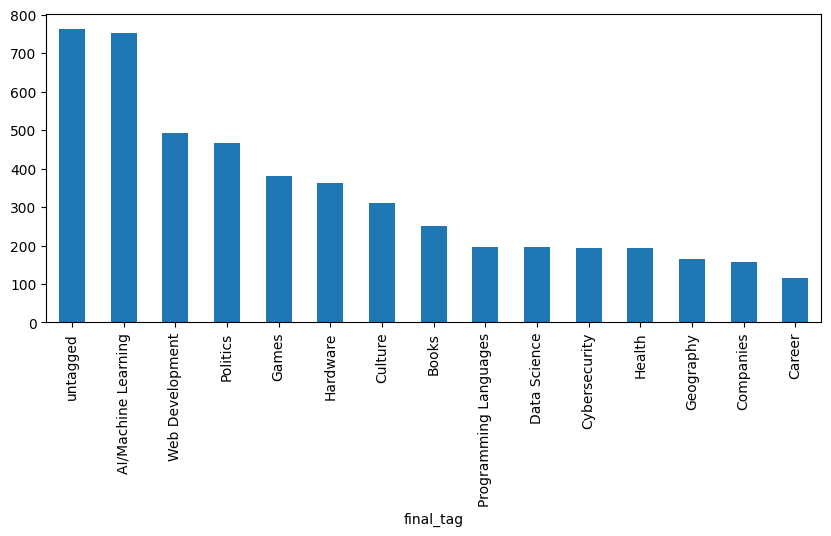

In [95]:
df["final_tag"].value_counts().plot(kind='bar', figsize=(10, 4))

In [96]:
df.to_csv("5000_with_labels.csv", index=False)

### SBERT + DBSCAN

In [97]:
from sentence_transformers import SentenceTransformer

# Load a pretrained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the clean_content of each document into a vector
embeddings = model.encode(df["clean_content"].tolist())
print("Embedding shape:", embeddings.shape)

Embedding shape: (5000, 384)


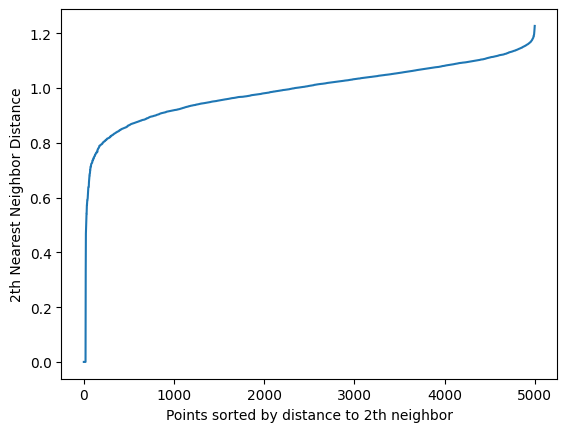

Estimated eps: 1.1116470098495483


In [98]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

min_samples = 2  # we include the point itself, so look at 4 neighbors
# Compute the distance to the 4th nearest neighbor for each point
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(embeddings)
distances, indices = nbrs.kneighbors(embeddings)

# distances[:, -1] gives the distance to the 4th nearest neighbor for each point
kdist = np.sort(distances[:, -1])  # sort the distances

# Plot k-distance graph to find the elbow
import matplotlib.pyplot as plt
plt.plot(kdist)
plt.xlabel('Points sorted by distance to 2th neighbor')
plt.ylabel('2th Nearest Neighbor Distance')
plt.show()

# Heuristic: choose eps at the elbow of this plot.
eps = kdist[int(0.9 * len(kdist))]  # e.g., 90th percentile distance as an estimate
print("Estimated eps:", eps)

In [99]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=1.11, min_samples=2, metric='euclidean')  # metric='euclidean' is default
clusters = dbscan.fit_predict(embeddings)

# `clusters` now contains cluster labels for each document
print(np.unique(clusters))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49]


In [100]:
# We can calculate the number of clusters (excluding noise) and the number of noise points:
labels = clusters
num_clusters = len(set(labels) - {-1})
num_noise = np.sum(labels == -1)
print(f"Detected clusters (excluding noise): {num_clusters}")
print(f"Noise points: {num_noise}")

Detected clusters (excluding noise): 50
Noise points: 521


In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer

BLACKLIST = {
    "vs", "000", "like", "year", "years", "new", "just", "use", "12", "2025",
    "pass", "big", "best", "cheap", "based", "org", "pdf", "core", "number", "numbers"
}

def normalize_label(term):
    return None if term in BLACKLIST or len(term) < 3 else term

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.9, min_df=2, max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df["clean_content"])
feature_names = vectorizer.get_feature_names_out()

cluster_labels = {}
for cid in np.unique(clusters):
    if cid == -1:
        cluster_labels[cid] = "Noise"
        continue
    idx = np.where(clusters == cid)[0]
    cluster_tfidf = tfidf_matrix[idx].mean(axis=0)
    top_index = cluster_tfidf.argmax()
    top_term = feature_names[top_index]
    clean_term = normalize_label(top_term)
    cluster_labels[cid] = clean_term if clean_term else "untagged"

df["dbscan_cluster"] = clusters
df["cluster_label"] = df["dbscan_cluster"].map(cluster_labels)

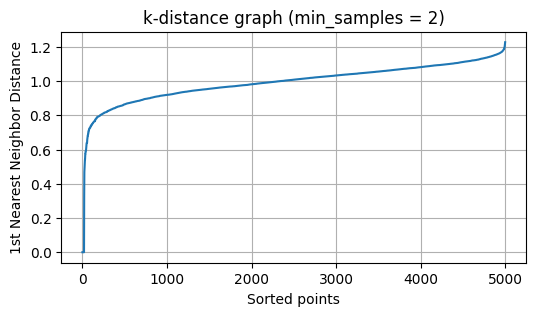

In [102]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

min_samples=2

# Compute distances to nearest neighbors using SBERT embeddings
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(embeddings)
distances, indices = nbrs.kneighbors(embeddings)

# Plot the distance to the (min_samples - 1)th neighbor → index -1
plt.figure(figsize=(6, 3))
plt.plot(np.sort(distances[:, -1]))  # Distance to 1st neighbor
plt.xlabel("Sorted points")
plt.ylabel("1st Nearest Neighbor Distance")
plt.title("k-distance graph (min_samples = 2)")
plt.grid(True)
plt.show()


In [103]:
df["cluster_label"].value_counts()

cluster_label
untagged     4420
Noise         521
actions         3
broken          3
generated       3
energy          3
car             3
age             2
major           2
set             2
following       2
com watch       2
paper           2
light           2
lost            2
building        2
human           2
history         2
analysis        2
question        2
client          2
custom          2
party           2
python          2
sell            2
quality         2
game            2
published       2
states          2
Name: count, dtype: int64